In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [3]:
data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
x_data = data['pixels']
y_data = data['emotion']

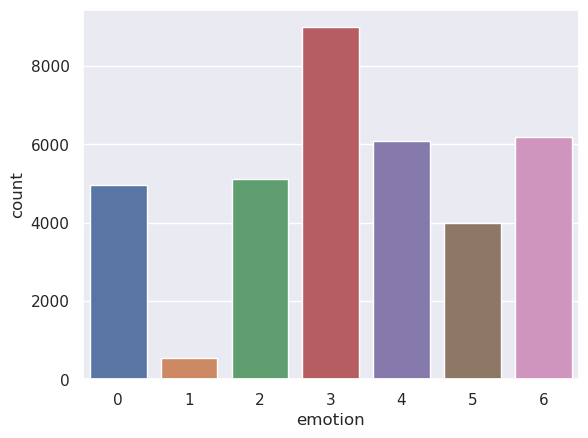

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    13 14 21 17 21 31 38 56 92 135 173 184 188 187...
62919    63 22 20 28 30 32 35 33 29 36 50 33 40 54 62 7...
62920    77 62 37 59 65 70 90 130 185 221 218 226 229 2...
62921    28 23 35 57 78 99 142 145 119 120 126 126 121 ...
62922    47 40 37 35 43 47 46 42 36 38 43 48 50 47 43 5...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [11]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [12]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [14]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

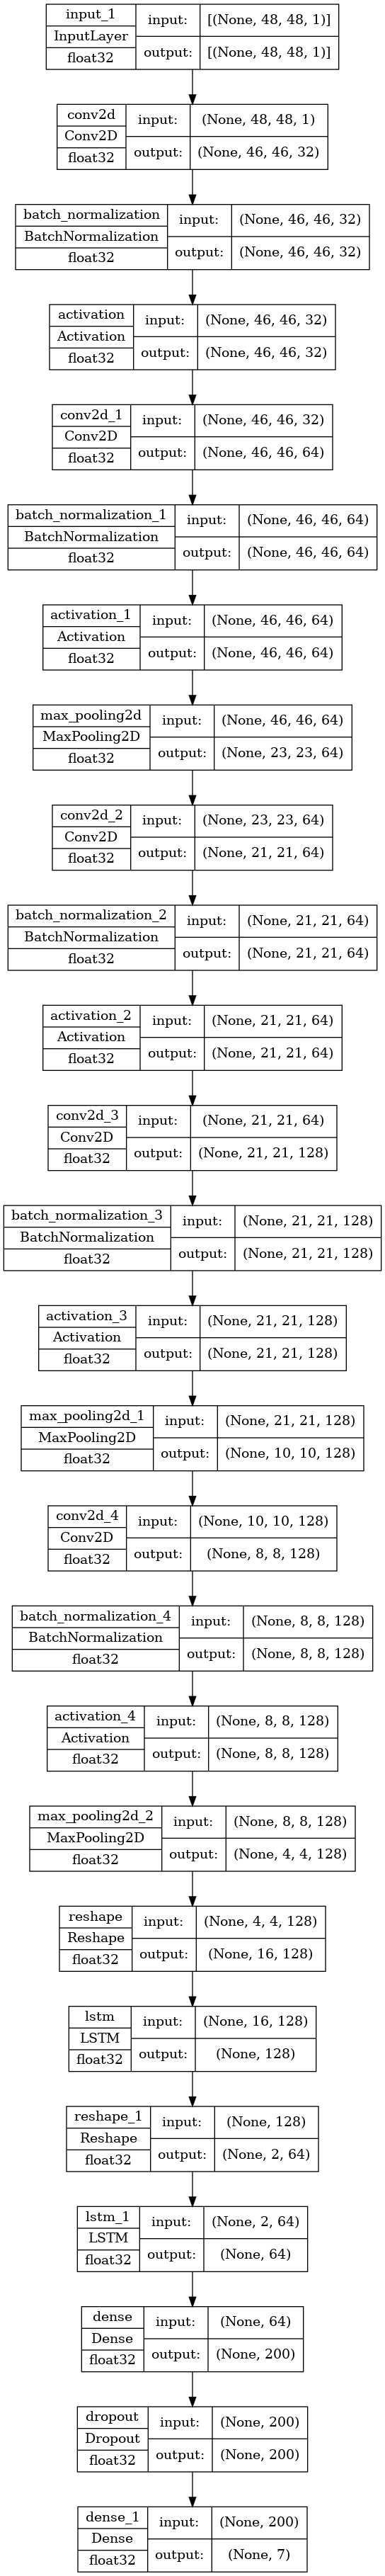

In [15]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [16]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [18]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [19]:
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_test, y_test))

Epoch 1/100
1770/1770 [==============================] - 36s 13ms/step - loss: 1.4697 - accuracy: 0.4286 - val_loss: 1.2525 - val_accuracy: 0.5098
Epoch 2/100
1770/1770 [==============================] - 21s 12ms/step - loss: 1.0468 - accuracy: 0.5987 - val_loss: 1.0013 - val_accuracy: 0.6139
Epoch 3/100
1770/1770 [==============================] - 21s 12ms/step - loss: 0.8942 - accuracy: 0.6634 - val_loss: 0.9309 - val_accuracy: 0.6488
Epoch 4/100
1770/1770 [==============================] - 21s 12ms/step - loss: 0.7732 - accuracy: 0.7161 - val_loss: 0.8297 - val_accuracy: 0.6911
Epoch 5/100
1770/1770 [==============================] - 21s 12ms/step - loss: 0.6542 - accuracy: 0.7648 - val_loss: 0.8479 - val_accuracy: 0.6928
Epoch 6/100
1770/1770 [==============================] - 21s 12ms/step - loss: 0.5553 - accuracy: 0.8046 - val_loss: 0.8033 - val_accuracy: 0.7184
Epoch 7/100
1770/1770 [==============================] - 22s 12ms/step - loss: 0.4667 - accuracy: 0.8414 - val_loss: 0

In [20]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 6ms/step - loss: 1.2432 - accuracy: 0.8473
Accuracy of our model on validation data :  84.72906351089478 %


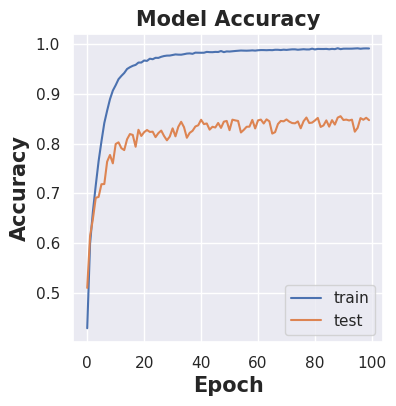

In [28]:

cm = plt.figure(figsize = (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 15, fontweight=1000)
plt.ylabel('Accuracy', fontsize = 15, fontweight=700)
plt.xlabel('Epoch', fontsize = 15, fontweight=700)
plt.legend(['train', 'test'], loc='lower right')
cm.savefig("model_acc")
plt.show()

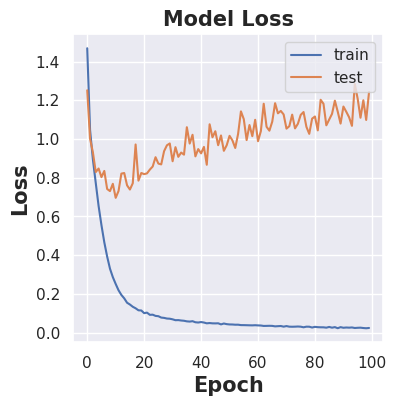

In [29]:
# summarize history for loss
cm = plt.figure(figsize = (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 15, fontweight=1000)
plt.ylabel('Loss', fontsize = 15, fontweight=700)
plt.xlabel('Epoch', fontsize = 15, fontweight=700)
plt.legend(['train', 'test'], loc='upper right')
cm.savefig("model_loss")
plt.show()

In [23]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 2s 4ms/step


[6, 5, 3, 6, 1, 0, 3, 4, 1, 2]

In [24]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       935
           1       0.99      0.99      0.99       895
           2       0.82      0.79      0.81       880
           3       0.87      0.81      0.84       906
           4       0.80      0.72      0.76       888
           5       0.90      0.96      0.93       869
           6       0.74      0.81      0.77       920

    accuracy                           0.85      6293
   macro avg       0.85      0.85      0.85      6293
weighted avg       0.85      0.85      0.85      6293



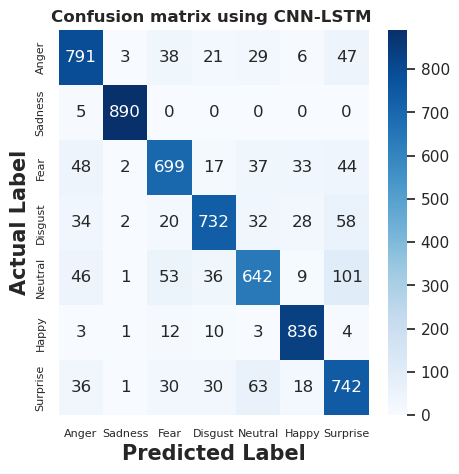

In [35]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

# plt.figure(figsize = (6,4))
# sn.heatmap(cm,cmap="Purples", annot = True, fmt = 'd')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig("confusion")

import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (5,5))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=8);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=8);

plt.title('Confusion matrix using CNN-LSTM ', fontsize = 12, fontweight=1000)
plt.xlabel('Predicted Label', fontsize = 15, fontweight=1000)
plt.ylabel('Actual Label', fontsize = 15, fontweight=1000)


plt.savefig("confusion")